# RO Flowsheet with Energy Recovery Device Build

This tutorial will walk you through creating a reverse osmosis (RO) flowsheet with an energy recovery device (ERD) unit model from top to bottom - building on the RO flowsheet constructed during class in RO_flowsheet_build.ipynb. 

<center><img src="../graphics/RO_with_ERD.png" width="600" /></center>


By the end of this tutorial you should be able to follow the workflow below to construct a simple flowsheet.


## Step 1: Import Modules

In [1]:
# Imports from Pyomo
from pyomo.environ import (
    ConcreteModel,
    Var,
    Param,
    Constraint,
    Objective,
    value,
    assert_optimal_termination,
    TransformationFactory,
    units as pyunits,
)
from pyomo.network import Arc

# Imports from IDAES
from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Feed, Product
from idaes.core.util.model_statistics import degrees_of_freedom
from idaes.core.util.scaling import calculate_scaling_factors, set_scaling_factor
from idaes.core.util.initialization import propagate_state

# Imports from WaterTAP
from watertap.property_models.seawater_prop_pack import SeawaterParameterBlock
from watertap.unit_models.pressure_changer import Pump
from watertap.unit_models.pressure_changer import EnergyRecoveryDevice
from watertap.unit_models.reverse_osmosis_0D import (
    ReverseOsmosis0D,
    ConcentrationPolarizationType,
    MassTransferCoefficient,
    PressureChangeType,
)
from watertap.core.solvers import get_solver

## Step 2: Build Model

### Step 2a: Create Model Object

In [2]:
# Create a model object using ConcreteModel
m = ConcreteModel()

### Step 2b: Add Flowsheet to Model

In [3]:
# Add the flowsheet to the model using FlowsheetBlock
# and set the dynamic configuration to False
m.fs = FlowsheetBlock(dynamic=False)

### Step 2c: Add Property Packages to Flowsheet

In [4]:
# Add the Seawater property package
m.fs.properties = SeawaterParameterBlock()

### Step 2d: Add Unit Models to Flowsheet


Add the unit models for Feed, Pump, RO, ERD, and Product. Keep in mind that all unit models have at least one configuration argument `property_package` that must be specified. For the RO model, set the configuration arguments such that it accounts for pressure change and the PressureChangeType, MassTransferCoefficient, and ConcentrationPolarizationType are all calculated.

<details>
  <summary>Click the arrow for a hint!</summary>
    
Unit models are defined with the following syntax: `m.fs.UserDefinedName = UnitModel(property_package=m.fs.PropertyPackage)`
</details>

In [5]:
# Add feed
m.fs.feed = Feed(property_package=m.fs.properties)
# Add pump
m.fs.pump = Pump(
    property_package=m.fs.properties,
)

# Add 0D reverse osmosis unit
m.fs.RO = ReverseOsmosis0D(
    property_package=m.fs.properties,
    has_pressure_change=True,
    pressure_change_type=PressureChangeType.calculated,
    mass_transfer_coefficient=MassTransferCoefficient.calculated,
    concentration_polarization_type=ConcentrationPolarizationType.calculated,
)

# Add Energy Recovery Device - check the imports if you're not sure of the unit model's name
m.fs.erd = EnergyRecoveryDevice(property_package=m.fs.properties)
# Add product stream
m.fs.product = Product(property_package=m.fs.properties)

### Step 2e: Define Unit Model Connectivity



Next, establish the connections betweeen unit models by creating an `Arc` between the `Ports` on each unit model. 

<details>
  <summary>Click the arrow for hint #1!</summary>
    
Arcs are defined with the following syntax: `m.fs.UserDefinedName = Arc(source=m.fs.UnitModelName.port, destination=m.fs.UnitModelName.port)`
</details>

<details>
  <summary>Click the arrow for hint #2!</summary>
    
In the schematic at the top of this tutorial there are 4 arrows (streams), so there should be four Arcs
</details>

In [6]:
# Define the connectivity using Arcs
m.fs.feed_to_pump = Arc(source=m.fs.feed.outlet, destination=m.fs.pump.inlet)
m.fs.pump_to_RO = Arc(source=m.fs.pump.outlet, destination=m.fs.RO.inlet)
m.fs.RO_to_erd = Arc(source=m.fs.RO.retentate, destination=m.fs.erd.inlet)
m.fs.RO_to_product = Arc(source=m.fs.RO.permeate, destination=m.fs.product.inlet)

### Step 2f: Expand Arcs



After establishing these connection, the arcs are expanded to create the constraints between all the state variables.

In [7]:
# Use the TransformationFactory to expand the arcs
TransformationFactory("network.expand_arcs").apply_to(m)

## Step 3: Specify Model



As before, we must provide parameter values for all the degrees of freedom on the model. Note that the `product` block is fully specified by its connected arcs, so we don't need to explicitly specify any of its degrees of freedom.

For each of the following unit models, specify the following conditions:

**Feed**
- Volumetric liquid flow rate: 1e-3 m3/s
- Mass concentration of liquid TDS: 35 kg/m3
- Pressure: 101325 Pa
- Temperature: 298.15 K

**Pump**
- Pump efficiency: 80%
- Outlet pressure: 75 bar

**Reverse Osmosis**
- Membrane water permeability: 4.12e-12
- Membrane salt permeability: 3.5e-8
- Volumetric reecovery of liquid: 0.5%
- Feed side channel_height: 1e-3 m
- Feed side spacer_porosity: 0.97
- Permeate side pressure: 101325 Pa
- Membrane area: 50 m2

**Energy Recovery Device**
- Pump efficiency: 95%
- Outlet pressure 101325 Pa

<details>
  <summary>Click the arrow for a hint!</summary>
    
**Feed**
- `flow_vol_phase["Liq"]`: 1e-3 m3/s
- `conc_mass_phase_comp["Liq", "TDS"]`: 35 kg/m3
- `pressure`: 101325 Pa
- `temperature`: 298.15 K

**Pump**
- `efficiency_pump`: 80%
- control volume outlet `pressure`: 75 bar

**Reverse Osmosis**
- `A_comp`: 4.12e-12
- `B_comp`: 3.5e-8
- `recovery_vol_phase["Liq"]`: 0.5%
- feed side `channel_height`1e-3 m
- feed side `spacer_porosity`: 0.97
- permeate `pressure`: 101325 Pa
- `area`: 50 m2

**Energy Recovery Device**
- `efficiency_pump`: 95%
- outlet `pressure` 101325 Pa
</details>



In [8]:
# Feed, 4 degrees of freedom
m.fs.feed.properties[0].flow_vol_phase["Liq"].fix(1e-3)
m.fs.feed.properties[0].conc_mass_phase_comp["Liq", "TDS"].fix(35)
m.fs.feed.properties[0].pressure.fix(101325)
m.fs.feed.properties[0].temperature.fix(273.15 + 25)

# Pump, 2 degrees of freedom
m.fs.pump.efficiency_pump.fix(0.80)
m.fs.pump.control_volume.properties_out[0].pressure.fix(75 * pyunits.bar)

# RO unit, 7 degrees of freedom
m.fs.RO.A_comp.fix(4.2e-12)
m.fs.RO.B_comp.fix(3.5e-8)
m.fs.RO.recovery_vol_phase[0, "Liq"].fix(0.5)
# m.fs.RO.feed_side.velocity[0, 0].fix(0.15)
m.fs.RO.feed_side.channel_height.fix(1e-3)
m.fs.RO.feed_side.spacer_porosity.fix(0.97)
m.fs.RO.permeate.pressure[0].fix(101325)
m.fs.RO.area.fix(50)

# ERD, 2 degrees of freedom
m.fs.erd.efficiency_pump.fix(0.95)
m.fs.erd.outlet.pressure[0].fix(101325)

# Print the degrees of freedom
print("DOF = ", degrees_of_freedom(m))

DOF =  0


## Step 4: Scale Model



Scaling ensures that all numerical quantities fall within similar, moderate magnitudes, improving model stability.

First we set default scaling factors for our state variables. Then we set custom scaling factors for the work done by the pump as well as the RO membrane area. Lastly, we use `calculate_scaling_factors` on the model, `m`, which will set scaling factors for the remaining variables on the model.

<details>
  <summary>Click the arrow for hint #1!</summary>
    
The syntax for setting default scaling factors on a property model is: `m.fs.PropertyModelName.set_default_scaling("VariableName", scaling factor, index=("Index for VariableName",...)`
</details>

<details>
  <summary>Click the arrow for hint #2!</summary>
    
The syntax for setting scaling factors on a unit model is: `set_scaling_factor(m.fs.UnitModelName.VariableName)` or `set_scaling_factor(m.fs.UnitModelName.control_volume.VariableName)`
</details>

In [9]:
# Set default property values
m.fs.properties.set_default_scaling("flow_mass_phase_comp", 1, index=("Liq", "H2O"))
m.fs.properties.set_default_scaling("flow_mass_phase_comp", 1e2, index=("Liq", "TDS"))

# Set unit model values
set_scaling_factor(m.fs.pump.control_volume.work, 1e-3)
set_scaling_factor(m.fs.RO.area, 1e-2)

# Calculate and propagate scaling factors
calculate_scaling_factors(m)

2025-12-01 13:47:21 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.erd.control_volume.work


## Step 5: Initialize Model



After the model is scaled, we move to initialization. Initialization can be thought of solving each model in a vacuum, without any relation to the up or downstream effects. For the other steps in this workflow, the order with respect to the process flow did not matter. However, initialization must proceed from the beginning to the end of the treatment train.

Starting with the `feed` block, the model is set to an initial point. After solving the feed block, we _propagate the state_ from the feed `outlet` to the pump `inlet`. When we know the state of the pump inlet, we can solve the pump model and further propagate down stream, and so on.

<details>
  <summary>Click the arrow for hint #1!</summary>
    
The syntax for solving a model is: `solver.solve(m.fs.UnitModelName)`
</details>

<details>
  <summary>Click the arrow for hint #2!</summary>
    
The syntax for propagating the state is: `propagate_state(m.fs.ArcName)`
</details>

<details>
  <summary>Click the arrow for hint #3!</summary>
    
The syntax for initializing a unit model is: `m.fs.UnitModelName.initialize()`
</details>

In [10]:
# Get WaterTAP solver
solver = get_solver()

# solve feed
solver.solve(m.fs.feed)

# Propagate state from feed to pump
propagate_state(m.fs.feed_to_pump)

# Initialize pump
m.fs.pump.initialize()
# Propagate state from pump to RO
propagate_state(m.fs.pump_to_RO)
# Initialize RO
m.fs.RO.initialize()

# Propagate state from RO to ERD and product
propagate_state(m.fs.RO_to_erd)
propagate_state(m.fs.RO_to_product)

# Initialize the product and ERD
m.fs.product.initialize()
m.fs.erd.initialize()

2025-12-01 13:47:23 [INFO] idaes.init.fs.pump.control_volume.properties_out: fs.pump.control_volume.properties_out State Released.
2025-12-01 13:47:23 [INFO] idaes.init.fs.pump.control_volume: Initialization Complete
component keys that are not exported as part of the NL file.  Skipping.
that are not Var, Constraint, Objective, or the model.  Skipping.
2025-12-01 13:47:23 [INFO] idaes.init.fs.pump.control_volume.properties_in: fs.pump.control_volume.properties_in State Released.
2025-12-01 13:47:23 [INFO] idaes.init.fs.pump: Initialization Complete: optimal - Optimal Solution Found
2025-12-01 13:47:24 [INFO] idaes.init.fs.RO.feed_side.properties_out: fs.RO.feed_side.properties_out State Released.
2025-12-01 13:47:24 [INFO] idaes.init.fs.RO.feed_side.properties_interface: fs.RO.feed_side.properties_interface State Released.
2025-12-01 13:47:24 [INFO] idaes.init.fs.RO.feed_side: Initialization Complete
2025-12-01 13:47:24 [INFO] idaes.init.fs.RO.permeate_side: fs.RO.permeate_side State R

## Step 6: Solve Model



In [11]:
# Solve the model and assert the the model has reached optimal termination
results = solver.solve(m, tee=True)
assert_optimal_termination(results)
print(
    f"Solver Status: {results.solver.status}, Termination Condition: {results.solver.termination_condition}"
)

ipopt-watertap: ipopt with user variable scaling and IDAES jacobian constraint scaling
Ipopt 3.13.2: tol=1e-08
constr_viol_tol=1e-08
acceptable_constr_viol_tol=1e-08
bound_relax_factor=0.0
honor_original_bounds=no
nlp_scaling_method=user-scaling


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, 

In [12]:
# Report unit-level performance results for (1) the pump, (2) RO and (3) the energy recovery device, using the report() method for each unit on the flowsheet.

m.fs.pump.report()
m.fs.RO.report()
m.fs.erd.report()


Unit : fs.pump                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value      : Units         : Fixed : Bounds
         Efficiency :    0.80000 : dimensionless :  True : (None, None)
    Mechanical Work :     9248.3 :          watt : False : (None, None)
    Pressure Change : 7.3987e+06 :        pascal : False : (None, None)
     Pressure Ratio :     74.019 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                              Units           Inlet     Outlet  
    flow_mass_phase_comp ('Liq', 'H2O')  kilogram / second    0.98796    0.98796
    flow_mass_phase_comp ('Liq', 'TDS')  kilogram / second   0.035000   0.035000
    temperature                                     kelvin     298.15     298.15
    press

## Step 7: Add Costing

In [13]:
# Import costing package
from watertap.costing import WaterTAPCosting
from idaes.core import UnitModelCostingBlock

# Add costing
m.fs.costing = WaterTAPCosting()
m.fs.costing.base_currency = pyunits.USD_2020
m.fs.pump.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
m.fs.RO.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)
m.fs.erd.costing = UnitModelCostingBlock(flowsheet_costing_block=m.fs.costing)

# Process costing 
m.fs.costing.cost_process()

# Add system level metrics
m.fs.costing.add_annual_water_production(m.fs.product.properties[0].flow_vol)
m.fs.costing.add_LCOW(m.fs.product.properties[0].flow_vol)
m.fs.costing.add_specific_energy_consumption(m.fs.product.properties[0].flow_vol)

# Initialize costing
m.fs.costing.initialize()

# ReSolve the model and assert the the model has reached optimal termination
results = solver.solve(m, tee= True)
assert_optimal_termination(results)
print(
    f"Solver Status: {results.solver.status}, Termination Condition: {results.solver.termination_condition}"
)

2025-12-01 13:47:27 [WARNING] idaes.core.base.costing_base: flow_expr is an expression with a lower bound of less than zero. Costing requires that all flows have a lower bound equal to or greater than zero to avoid negative costs.
ipopt-watertap: ipopt with user variable scaling and IDAES jacobian constraint scaling
Ipopt 3.13.2: tol=1e-08
constr_viol_tol=1e-08
acceptable_constr_viol_tol=1e-08
bound_relax_factor=0.0
honor_original_bounds=no
nlp_scaling_method=user-scaling


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDA

In [14]:
# Display costing metrics
print("Levelized cost of water: %.2f $/m3" % value(m.fs.costing.LCOW))
print("Total operating cost: %.4g $/yr" % value(m.fs.costing.total_operating_cost))
print("Total capital cost: %.4g $" % value(m.fs.costing.total_capital_cost))
print("Total annualized cost: %.4g $/yr" % value(m.fs.costing.total_annualized_cost))
print("Specific energy consumption: %.1f kWh/m3" % value(m.fs.costing.specific_energy_consumption))
print("Capital cost pump: %.4g $" % value(m.fs.pump.costing.capital_cost))
print("Capital cost RO: %.4g $" % value(m.fs.RO.costing.capital_cost))
print("Capital cost ERD: %.4g $" % value(m.fs.erd.costing.capital_cost))

Levelized cost of water: 0.61 $/m3
Total operating cost: 4756 $/yr
Total capital cost: 3.976e+04 $
Total annualized cost: 8732 $/yr
Specific energy consumption: 3.3 kWh/m3
Capital cost pump: 3.489e+04 $
Capital cost RO: 2966 $
Capital cost ERD: 1906 $


In [15]:
m.fs.pump.report()


Unit : fs.pump                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key             : Value      : Units         : Fixed : Bounds
         Efficiency :    0.80000 : dimensionless :  True : (None, None)
    Mechanical Work :     9248.3 :          watt : False : (None, None)
    Pressure Change : 7.3987e+06 :        pascal : False : (None, None)
     Pressure Ratio :     74.019 : dimensionless : False : (None, None)

------------------------------------------------------------------------------------
    Stream Table
                                              Units           Inlet     Outlet  
    flow_mass_phase_comp ('Liq', 'H2O')  kilogram / second    0.98796    0.98796
    flow_mass_phase_comp ('Liq', 'TDS')  kilogram / second   0.035000   0.035000
    temperature                                     kelvin     298.15     298.15
    press

## Step 9: Sensitivity Analysis

ipopt-watertap: ipopt with user variable scaling and IDAES jacobian constraint scaling
Ipopt 3.13.2: tol=1e-08
constr_viol_tol=1e-08
acceptable_constr_viol_tol=1e-08
bound_relax_factor=0.0
honor_original_bounds=no
nlp_scaling_method=user-scaling


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, 

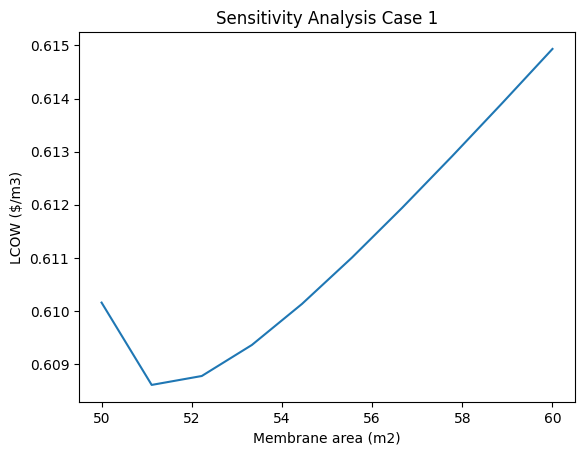

In [16]:
# Import packages for plotting
import numpy as np
import matplotlib.pyplot as plt

# Case 1 - LCOW vs memrane area
num = 10 # number for multiple implementations
area_list = np.linspace(50, 60, num)
LCOW_list = []

for i in range(0, num):
    try:
        m.fs.RO.area.unfix()
        m.fs.RO.feed_side.velocity[0, 0].fix(0.15)
        results = solver.solve(m, tee= False)
        m.fs.RO.feed_side.velocity[0, 0].unfix()
        #m.fs.RO.feed_side.velocity[0, 0].fix(float(area_list[i]))
        m.fs.RO.area.fix(float(area_list[i]))
        results = solver.solve(m, tee= True)
        assert_optimal_termination(results)
        LCOW_list.append(value(m.fs.costing.LCOW))
        #LCOW_list.append(value(m.fs.RO.area))
        #LCOW_list.append(1)
    except:
        LCOW_list.append(0)
        pass

# m = build_RO_flowsheet()
# m = initialize_and_solve_RO_flowsheet(m)
# plot
print(area_list)
print(LCOW_list)
plt.figure()
plt.plot(area_list, LCOW_list)
plt.xlabel("Membrane area (m2)")
plt.ylabel("LCOW ($/m3)")
plt.title("Sensitivity Analysis Case 1")

plt.show()

## Step 8: Setup Optimization

In [17]:
# Add objective function
m.fs.objective = Objective(expr=m.fs.costing.LCOW)

# Unfix decision variables - pump
m.fs.pump.control_volume.properties_out[0].pressure.unfix()
m.fs.pump.control_volume.properties_out[0].pressure.setlb(10e5)
m.fs.pump.control_volume.properties_out[0].pressure.setub(85e5)
m.fs.pump.deltaP.setlb(0)

# Unfix decision variables - RO
m.fs.RO.area.unfix()
m.fs.RO.area.setlb(1)
m.fs.RO.area.setub(1500)
m.fs.RO.feed_side.friction_factor_darcy[...].setub(None)

# Add extra constraints
m.fs.product_salinity = Param(
    initialize=500e-6, mutable=True
)  # product NaCl mass fraction [-]
m.fs.minimum_water_flux = Param(
    initialize=1.0 / 3600.0, mutable=True
)  # minimum water flux [kg/m2-s]
m.fs.eq_product_quality = Constraint(
    expr=m.fs.product.properties[0].mass_frac_phase_comp["Liq", "TDS"]
    <= m.fs.product_salinity
)
m.fs.eq_minimum_water_flux = Constraint(
    expr=m.fs.RO.flux_mass_phase_comp[0, 1, "Liq", "H2O"] >= m.fs.minimum_water_flux
)

# Solve the optimization
results = solver.solve(m, tee = True)
assert_optimal_termination(results)
print(
    f"Solver Status: {results.solver.status}, Termination Condition: {results.solver.termination_condition}"
)

ipopt-watertap: ipopt with user variable scaling and IDAES jacobian constraint scaling
Ipopt 3.13.2: tol=1e-08
constr_viol_tol=1e-08
acceptable_constr_viol_tol=1e-08
bound_relax_factor=0.0
honor_original_bounds=no
nlp_scaling_method=user-scaling


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, 

In [18]:
# Display costing metrics
print("Levelized cost of water: %.2f $/m3" % value(m.fs.costing.LCOW))

Levelized cost of water: 0.50 $/m3


In [19]:
# Display decision variables
print("Operating pressure %.1f bar" % (m.fs.RO.inlet.pressure[0].value / 1e5))
print("Membrane area %.1f m2" % (m.fs.RO.area.value))

Operating pressure 50.0 bar
Membrane area 132.3 m2
